In [1]:
import numpy as np
from scipy import integrate, interpolate
import matplotlib.pyplot as plt

In [2]:
# BSM model
from scipy import optimize
def CND(X):
 
    (a1,a2,a3,a4,a5) = (0.31938153, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    
    L = abs(X)
    K = 1.0 / (1.0 + 0.2316419 * L)
    w = 1.0 - 1.0 / np.sqrt(2*np.pi)*np.exp(-L*L/2.) * (a1*K + a2*K*K + a3*pow(K,3) + a4*pow(K,4) + a5*pow(K,5))
    
    if X<0:
        w = 1.0-w
 
    return w

def BlackScholes(v,CallPutFlag = 'c',S = 100.,X = 100.,T = 1.,r = 0.01):
 
    d1 = (np.log(S/X)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    
    if CallPutFlag=='c':
        return S*CND(d1)-X*np.exp(-r*T)*CND(d2)
 
    else:
        return X*np.exp(-r*T)*CND(-d2)-S*CND(-d1)
    
def calc_impl_vol(price = 5., right = 'c', underlying = 100., strike = 100., time = 1., rf = 0.0):
    
    def f(x):
        out = (BlackScholes(x,CallPutFlag=right,S=underlying,X=strike,T=time,r=rf)-price)**2 
        if x < 0.0:
            out += 1000.0 * (x)**2
        return out
  
    return optimize.minimize(f,x0=0.5, tol=1e-8, method='Nelder-Mead')

def get_aux_params(u, j, theta, kappa, sigma, rho):
    alpha = - u**2 /2. - 1j*u/2. + 1j*j*u
    beta = kappa - rho*sigma*j - rho*sigma*1j*u
    gamma = sigma**2/2
    d = np.sqrt(beta**2 - 4.*alpha*gamma)
    r_p = (beta + d)/sigma**2
    r_n = (beta - d)/sigma**2
    g = r_n/r_p
    return alpha, beta, gamma, d, r_p, r_n, g

def get_C_D(u, j, tau, theta, kappa, sigma, rho):
    _, _, _, d, _, r_n, g = get_aux_params(u, j, theta, kappa, sigma, rho)
    d_tau = d*tau
    C = kappa*(r_n*tau - 2./sigma**2*np.log((1.-g*np.exp(-d_tau))/(1.-g)))
    D = r_n*(1.-np.exp(-d_tau))/(1.-g*np.exp(-d_tau))
    return C, D

def get_integrand(v0, x, u, j, tau, theta, kappa, sigma, rho):
    C,D = get_C_D(u, j, tau, theta, kappa, sigma, rho)
    return ((np.exp(C*theta + D*v0 + 1j*u*x)) / (1j*u)).real

def P(v0, x, j, tau, theta, kappa, sigma, rho):
    def wrapper(u):
        return get_integrand(v0,x, u, j, tau, theta, kappa, sigma, rho)    
    
    if tau <= 1e-4:
        tau = 1e-4
    float_epsilon = np.finfo(float).eps
    integral,err =  integrate.quad(wrapper,float_epsilon,4000.0)
    return 0.5 + 1./np.pi * integral
    
def get_call_price(v0, spot, K, tau, theta, kappa, sigma, rho):
    # presume zero risk-free
    x= np.log(spot/K)
    P0 = P(v0, x, 0, tau, theta, kappa, sigma, rho)
    P1 = P(v0, x, 1, tau, theta, kappa, sigma, rho)
    price = spot * P1 - K * P0
    return price

def get_CIR_Sample(NoOfPaths,kappa,gamma,vbar,s,t,v_s):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    sample = c* np.random.noncentral_chisquare(delta,kappaBar,NoOfPaths)
    return sample

def getEVBinMethod(S,v,NoOfBins):
    if (NoOfBins != 1):
        mat  = np.transpose(np.array([S,v]))
       
        # Sort all the rows according to the first column

        val = mat[mat[:,0].argsort()]
        
        binSize = int((np.size(S)/NoOfBins))
         
        expectation = np.zeros([np.size(S),2]) # columns of S and v

        for i in range(1,binSize-1):
            sample = val[(i-1)*binSize:i*binSize,1]
            expectation[(i-1)*binSize:i*binSize,0] =val[(i-1)*binSize:i*binSize,0]
            expectation[(i-1)*binSize:i*binSize,1] =np.mean(sample)
        return expectation

In [13]:
# Price surface using Heston model

theta = 0.132328; kappa = 10.980797; sigma = 1.7; rho = -0.351560; v0 = 0.065690
o_theta,o_kappa,o_sigma,o_rho,o_v0 = theta,kappa,sigma,rho,v0
r = 0.0 # always presume zero risk-free interest
#spot, K = 659.37, 758.28
# spot, K = 659.37, 600.0
# spot, K = 1.0, 0.9099595068019473
spot = 1.0; K_vec = np.linspace(0.8,1.2,num=30)
T_max = 3
# T_vec = np.linspace(0.25,T_max,int(((T_max)/0.25)))
T_vec = np.linspace(1/12,T_max,int(((T_max)/(1/12))))
float_epsilon = np.finfo(float).eps
#tau_vec = np.linspace(float_epsilon,0.1,num=100)
# tau_vec = np.linspace(float_epsilon,1.,num=13)
price_vec = []
ivol_vec = []
for tau in T_vec:
    price_tau=[get_call_price(v0, spot, k, tau, theta, kappa, sigma, rho) for k in K_vec]
    price_vec.append(np.array(price_tau))
    for (ind_k,k) in enumerate(K_vec):
        ivol_vec.append(calc_impl_vol(price = price_tau[ind_k], right = 'c', underlying = 1., strike = k, time = tau, rf = 0.0).x[0])
ivol_vec = np.array(ivol_vec).reshape(len(T_vec),-1)
ivol_vec

array([[0.3835077 , 0.37597474, 0.36843168, ..., 0.28056923, 0.28336813,
        0.2862582 ],
       [0.3737085 , 0.36779662, 0.36195533, ..., 0.28783945, 0.28882492,
        0.28998446],
       [0.36870131, 0.36403237, 0.35945752, ..., 0.29731701, 0.29734862,
        0.29752808],
       ...,
       [0.3588681 , 0.35840505, 0.35795247, ..., 0.34924474, 0.34897663,
        0.3487133 ],
       [0.35885735, 0.35840791, 0.35796858, ..., 0.34949959, 0.34923812,
        0.34898127],
       [0.35884747, 0.35841088, 0.35798404, ..., 0.34974108, 0.34948593,
        0.34923525]])

In [4]:
dk = K_vec[1] - K_vec[0]
dt = T_vec[1] - T_vec[0]
si_LV = []
for (i_t,tau) in enumerate(T_vec):
    lv_k = np.zeros(len(K_vec)) # local vol for each strike 
    for (i_k,k) in enumerate(K_vec):
        # derivatives w.r.t. T
        if i_t == 0: # left boundary
            v_t = (price_vec[i_t+1][i_k]-price_vec[i_t][i_k])/dt
        elif i_t == len(T_vec)-1: # right boundary
            v_t = (price_vec[i_t][i_k]-price_vec[i_t-1][i_k])/dt
        else:
            v_t = (price_vec[i_t+1][i_k]-price_vec[i_t-1][i_k])/(2.0*dt)
        
        # derivatives w.r.t. K
        if i_k == 0: # left boundary
            v_k = (price_vec[i_t][i_k+1]-price_vec[i_t][i_k])/dk
        elif i_k == len(K_vec)-1: # right boundary
            v_k = (price_vec[i_t][i_k]-price_vec[i_t][i_k-1])/dk
        else:
            v_kk = (price_vec[i_t][i_k+1] - 2.0*price_vec[i_t][i_k] + price_vec[i_t][i_k-1])/(dk**2)
            v_k = (price_vec[i_t][i_k+1]-price_vec[i_t][i_k-1])/(2.0*dk)
            lv_k[i_k] = np.sqrt((v_t+r*k*v_k)/(0.5*k**2 * v_kk))
        
    lv_k[0] = lv_k[1] + (lv_k[1] - lv_k[2]) # linear approx
    lv_k[len(K_vec)-1] = lv_k[len(K_vec)-2] + (lv_k[len(K_vec)-2] - lv_k[len(K_vec)-3]) #linear approx
    si_LV.append(lv_k)

si_LV = np.matrix(si_LV)
si_lv_func = interpolate.interp2d(K_vec,T_vec,si_LV)

In [14]:
# Run simulations to compute bins

# Deliberately run wrong params
level = 0.7
# level = 1.0
theta = level*o_theta; kappa = level*o_kappa; sigma = level*o_sigma; rho = level*rho; v0 = level*o_v0

np.random.seed(1)
T = T_vec[-1]
num_steps = int(T*4*3*5) # weekly
# num_steps = int(T*4*3*5*5) # daily
# num_paths = 7500
num_paths = 15000
num_paths = 50000
res = np.zeros((num_steps, num_paths))
dt = T/num_steps
t_sim = np.linspace(0.0,T,num_steps+1)

correlation = np.matrix([[1, rho],[rho, 1]])
L = np.linalg.cholesky(correlation)
alpha = kappa*theta
beta = kappa
s = np.zeros([num_steps+1, num_paths]) # log(S)
v = np.zeros([num_steps+1, num_paths])
v[0,:] = v0

for i in range(num_steps):
    # noncentral chisquare processes

    # Volatility
    dW_indep = np.random.normal(0.0,1.0,(2,num_paths))
    dW_indep = (dW_indep-dW_indep.mean(axis=1).reshape(-1,1))/dW_indep.std(axis=1).reshape(-1,1) # normalize
    dW = L*dW_indep*np.sqrt(dt) # each row (sA sB vA vB) 
#     dW   = np.random.multivariate_normal([0,0,0,0], p["correlation"], num_paths).transpose()*np.sqrt(dt)
    drift_term = (alpha - beta*v[i,:])*dt
    dWv = dW[0,:] # A or B
    vol_term = sigma*np.multiply(np.sqrt(v[i,:]),dWv)
    vol_term += 0.25*sigma**2.0 * (np.power(dWv,2) - dt) # Milstein term
    v[i+1,:] = np.maximum(0.0,v[i,:] + drift_term + vol_term) # truncation
    
    # Stock price
    drift_term = (r-0.5*v[i,:])*dt
    dWs = dW[1,:] 
    vol_term = np.multiply(np.sqrt(v[i,:]), dWs)
    s[i+1,:] = s[i,:] + drift_term + vol_term
    
S = np.exp(s) # stock price

# Check simulation result by pricing

In [15]:
mc_call = []
ivol_mc = []
for (ind, tau) in enumerate(T_vec):
    try:
        t_ind = np.where(t_sim == tau)[0][0] # index for the same value
    except:
        t_ind = np.where(t_sim <= tau)[0][-1] # closest index
    mc_payoff = np.zeros(len(K_vec)) # slv for each k 
    for (i_k,k) in enumerate(K_vec):
        payoff = S[t_ind] -k
        payoff = np.where(payoff < 0.0, 0.0, payoff) # modify payoff
        mc_payoff[i_k] = payoff.mean()
        ivol_mc.append(calc_impl_vol(price = mc_payoff[i_k], right = 'c', underlying = 1., strike = k, time = tau, rf = 0.0).x[0])
    mc_call.append(mc_payoff)
ivol_mc = np.array(ivol_mc).reshape(len(T_vec),-1)
ivol_mc

array([[0.30381092, 0.29896481, 0.29364184, ..., 0.2450726 , 0.2480109 ,
        0.25114802],
       [0.30702705, 0.30173652, 0.29642969, ..., 0.24960442, 0.25208018,
        0.25464994],
       [0.30614335, 0.30131724, 0.29654409, ..., 0.25487182, 0.25625429,
        0.2578505 ],
       ...,
       [0.30078771, 0.30039684, 0.30000032, ..., 0.29376361, 0.29360565,
        0.2934576 ],
       [0.30149151, 0.30111172, 0.30072539, ..., 0.2942475 , 0.29408832,
        0.29393451],
       [0.30209583, 0.30168202, 0.30128122, ..., 0.29481294, 0.29463865,
        0.29447461]])

In [16]:
"""NoOfBins = 25
# NoOfBins = 200
expectations = []
for (ind, tau) in enumerate(t_sim):
    f = getEVBinMethod(S[ind],v[ind],NoOfBins)
    ind = np.where(f[:,1]==0)[0] # drop empty rows
    f = np.delete(f, ind, 0)
    func = lambda x: np.interp(x, f[:,0], f[:,1])
    expectations.append(func)"""

'NoOfBins = 25\n# NoOfBins = 200\nexpectations = []\nfor (ind, tau) in enumerate(t_sim):\n    f = getEVBinMethod(S[ind],v[ind],NoOfBins)\n    ind = np.where(f[:,1]==0)[0] # drop empty rows\n    f = np.delete(f, ind, 0)\n    func = lambda x: np.interp(x, f[:,0], f[:,1])\n    expectations.append(func)'

In [17]:
NoOfBins = 25
# NoOfBins = 200
expectations = []
for (ind, tau) in enumerate(T_vec):
    try:
        t_ind = np.where(t_sim == tau)[0][0] # index for the same value
    except:
        t_ind = np.where(t_sim <= tau)[0][-1] # closest index
    f = getEVBinMethod(S[t_ind],v[t_ind],NoOfBins)
    ind = np.where(f[:,1]==0)[0] # drop empty rows
    f = np.delete(f, ind, 0)
    func = lambda x: np.interp(x, f[:,0], f[:,1])
    expectations.append(func)

In [18]:
si_slv = [] # list of lambda expressions for SLV
for (i_t,tau) in enumerate(T_vec):
    slv = np.zeros(len(K_vec)) # slv for each k 
    for (i_k,k) in enumerate(K_vec):
        v_expect = expectations[i_t](k)
        slv[i_k] = si_LV[i_t, i_k] / np.sqrt(v_expect)
    si_slv.append(slv)
    
si_slv = np.matrix(si_slv)
si_slv_func = interpolate.interp2d(K_vec,T_vec,si_slv)
si_slv_func(T,K_vec).reshape(-1)

array([1.15069508, 1.15198575, 1.15327641, 1.15445394, 1.15555065,
       1.15664737, 1.15774408, 1.1588408 , 1.15993751, 1.16094963,
       1.16189017, 1.16283071, 1.16377125, 1.16471179, 1.16565233,
       1.16652941, 1.16734304, 1.16815668, 1.16897031, 1.16978394,
       1.17059757, 1.17136349, 1.17207303, 1.17278257, 1.1734921 ,
       1.17420164, 1.17491118, 1.17558481, 1.17620817, 1.17683153])

# SLV model simulation

In [29]:
# Run simulations to compute bins

np.random.seed(1)
T = T_vec[-1]
num_steps = int(T*4*3*5) # weekly
# num_steps = int(T*4*3*5*5) # daily
# num_paths = 7500
num_paths = 15000
num_paths = 50000
res = np.zeros((num_steps, num_paths))
dt = T/num_steps
t_sim = np.linspace(0.0,T,num_steps+1)

correlation = np.matrix([[1, rho],[rho, 1]])
L = np.linalg.cholesky(correlation)
alpha = kappa*theta
beta = kappa
s = np.zeros([num_steps+1, num_paths]) # log(S)
v = np.zeros([num_steps+1, num_paths])
v[0,:] = v0

for i in range(num_steps):
    t = i*dt
    # noncentral chisquare processes

    # Volatility
    dW_indep = np.random.normal(0.0,1.0,(2,num_paths))
    dW_indep = (dW_indep-dW_indep.mean(axis=1).reshape(-1,1))/dW_indep.std(axis=1).reshape(-1,1) # normalize
    dW = L*dW_indep*np.sqrt(dt) # each row (sA sB vA vB) 

    # Vol of vol
    drift_term = (alpha - beta*v[i,:])*dt
    dWv = dW[0,:] # A or B
    vol_term = sigma*np.multiply(np.sqrt(v[i,:]),dWv)
    vol_term += 0.25*sigma**2.0 * (np.power(dWv,2) - dt) # Milstein term
    v[i+1,:] = np.maximum(0.0,v[i,:] + drift_term + vol_term) # truncation
    
    # Stock price
    S_i = np.exp(s[i,:])
    slv_i = si_slv_func(t,S_i).reshape(-1)
    drift_term = (r-0.5*np.multiply(v[i,:],np.power(slv_i,2)))*dt
    dWs = dW[1,:] 
    vol_term = np.multiply(slv_i, np.multiply(np.sqrt(v[i,:]), dWs))
    s[i+1,:] = s[i,:] + drift_term + vol_term
    
S = np.exp(s) # stock price

In [30]:
# Do pricing using the simulation data
slv_sim = []
ivol_slv = []
for (i_t,tau) in enumerate(T_vec):
    try:
        t_ind = np.where(t_sim == tau)[0][0] # index for the same value
    except:
        t_ind = np.where(t_sim <= tau)[0][-1] # closest index
    slv_payoff = np.zeros(len(K_vec)) # slv for each k 
    for (i_k,k) in enumerate(K_vec):
        payoff = S[t_ind] -k
        payoff = np.where(payoff < 0.0, 0.0, payoff) # modify payoff
        slv_payoff[i_k] = payoff.mean()
        ivol_slv.append(calc_impl_vol(price = slv_payoff[i_k], right = 'c', underlying = 1., strike = k, time = tau, rf = 0.0).x[0])
    slv_sim.append(slv_payoff)
ivol_slv = np.array(ivol_slv).reshape(len(T_vec),-1)


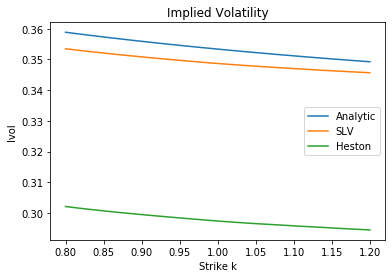

In [31]:
ind_sel = -1
# ind_sel = 4
plt.plot(K_vec, ivol_vec[ind_sel],label='Analytic')
plt.plot(K_vec, ivol_slv[ind_sel],label='SLV')
plt.plot(K_vec, ivol_mc[ind_sel],label='Heston')
plt.title("Implied Volatility")
plt.xlabel("Strike k")
plt.ylabel("Ivol")
plt.legend()